In [82]:
#Traemos el dataset desde la pagina de github
!wget https://github.com/ecabestadistica/sign-language-translator-python-opencv/raw/master/Sign-Language-Digits-Dataset-master.zip

--2023-11-23 14:52:50--  https://github.com/ecabestadistica/sign-language-translator-python-opencv/raw/master/Sign-Language-Digits-Dataset-master.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/ecabestadistica/sign-language-translator-python-opencv/master/Sign-Language-Digits-Dataset-master.zip [following]
--2023-11-23 14:52:50--  https://media.githubusercontent.com/media/ecabestadistica/sign-language-translator-python-opencv/master/Sign-Language-Digits-Dataset-master.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17256769 (16M) [application/zip]
Saving to: ‘Sign-Languag

In [ ]:
#simplemente para evitar problemas borramos carpeta previa en ruta de extración
!rm -rf Sign-Language-Digits-Dataset-master

In [122]:
!rm -rf datasetNumManu

In [83]:
#descomprimimos dataset y nos guardamos la ruta
!unzip Sign-Language-Digits-Dataset-master.zip

Archive:  Sign-Language-Digits-Dataset-master.zip
replace Sign-Language-Digits-Dataset-master/Dataset/0/IMG_1118.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [123]:
!unzip datasetNumManu.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: datasetNumManu/4/num4_3_lejos-img-00732.jpg  
  inflating: datasetNumManu/4/num4_3_lejos-img-00733.jpg  
  inflating: datasetNumManu/4/num4_3_lejos-img-00734.jpg  
  inflating: datasetNumManu/4/num4_3_lejos-img-00735.jpg  
  inflating: datasetNumManu/4/num4_3_lejos-img-00736.jpg  
  inflating: datasetNumManu/4/num4_3_lejos-img-00737.jpg  
  inflating: datasetNumManu/4/num4_3_lejos-img-00738.jpg  
  inflating: datasetNumManu/4/num4_3_lejos-img-00739.jpg  
  inflating: datasetNumManu/4/num4_3_lejos-img-00740.jpg  
  inflating: datasetNumManu/4/num4_3_lejos-img-00741.jpg  
  inflating: datasetNumManu/4/num4_3_lejos-img-00742.jpg  
  inflating: datasetNumManu/4/num4_3_lejos-img-00743.jpg  
  inflating: datasetNumManu/4/num4_3_lejos-img-00744.jpg  
  inflating: datasetNumManu/4/num4_3_lejos-img-00745.jpg  
  inflating: datasetNumManu/4/num4_3_lejos-img-00746.jpg  
  inflating: datasetNumManu/4/num4_3_lejos-img-00747.j

In [124]:
datasetPath='./datasetNumManu'
validationPath='./Sign-Language-Digits-Dataset-master/Dataset'

In [125]:
#importamos todas las librerias a usar
import tensorflow as tf

print(tf.__version__)
print(tf.config.list_physical_devices())

from tensorflow.keras                       import regularizers
from tensorflow.keras.models                import Sequential, Model
from tensorflow.keras.layers                import *
from tensorflow.keras.callbacks             import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers            import SGD

import matplotlib.pyplot as plt

2.14.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [126]:
#parametros configurables
bs = 32 #bach size
image_side = 100 #image is an square 56x56
epochs = 25

In [127]:
##Cargamos imagenes de la carpeta en un dataset
raw_train_ds = tf.keras.utils.image_dataset_from_directory(
  datasetPath,
  label_mode = "categorical",
  seed=123,
  image_size=(image_side, image_side),
  batch_size=bs)

raw_validation_ds = tf.keras.utils.image_dataset_from_directory(
  validationPath,
  label_mode = "categorical",
  seed=123,
  image_size=(image_side, image_side),
  batch_size=bs)

Found 8809 files belonging to 10 classes.
Found 2062 files belonging to 10 classes.


In [128]:
#definimos clases
class_names = raw_train_ds.class_names
print(class_names)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [129]:
#normalizamos dataset de escala 0,255 a 0,1
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = raw_train_ds.map(lambda x, y: (normalization_layer(x), y))
validation_ds = raw_validation_ds.map(lambda x, y: (normalization_layer(x), y))

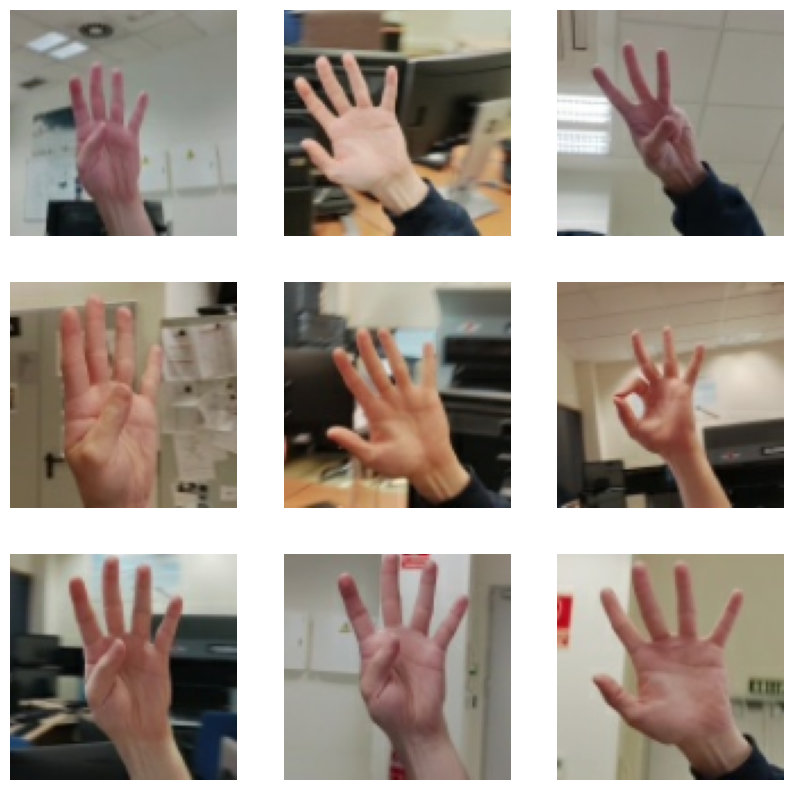

In [130]:
#Mostramos imagen de entrenamiento normalizada sin modificaciones
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  #images contiene un batch(32) de imagenes de 56x56x3
  #labels contiene un array de 32 arrays con 10 clases marcando un 1 o 0 dependiendo de la clase de cada imagen
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy()) ## usar .astype("uint8") si las imagenes van de 0 a 255 si no float 0 a 1
    #plt.title(class_names[labels[i].numpy().tolist().index(1)-2])
    plt.axis("off")

In [131]:
#Configuramos nuestra capa de data augmentation
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
        #tf.keras.layers.RandomZoom(0.1),
        tf.keras.layers.RandomBrightness((-0.3,0.3),value_range=(0,1)),
        tf.keras.layers.RandomTranslation(0.05, 0.2),
        #tf.keras.layers.RandomCrop(25,25),
        #tf.keras.layers.RandomContrast(0.3)
    ]
)
data_augmentation.build((None, image_side, image_side, 3)) ## this is important to prevent usage of data augmentation change his shape

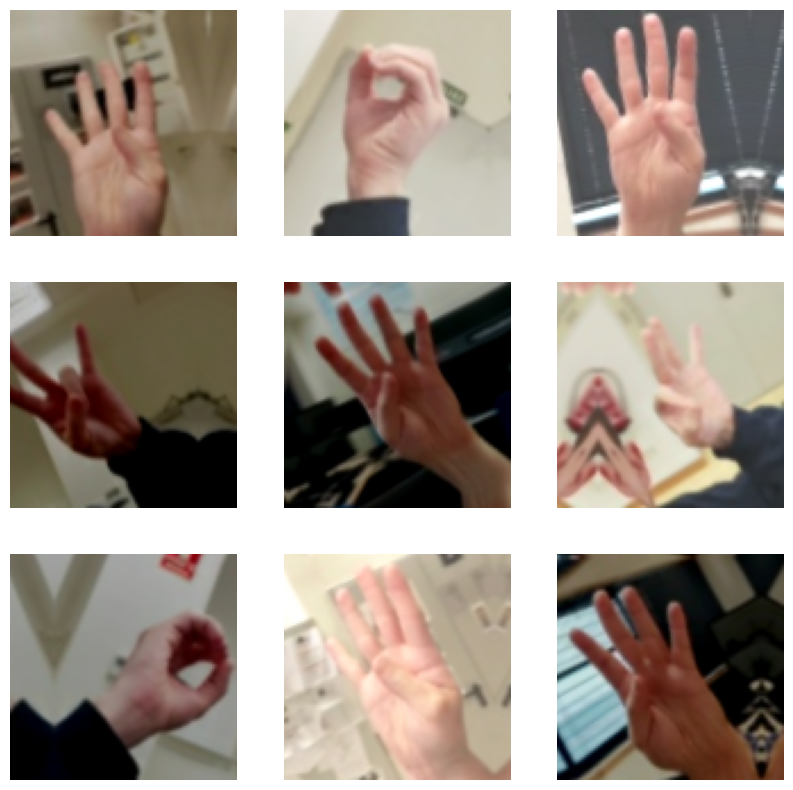

In [132]:
#probamos nuestro data augmentation
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  #images contiene un batch(32) de imagenes de 56x56x3
  #labels contiene un array de 32 arrays con 10 clases marcando un 1 o 0 dependiendo de la clase de cada imagen
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(data_augmentation(images[i].numpy())) ## usar .astype("uint8") si las imagenes van de 0 a 255 si no float 0 a 1
    #plt.title(class_names[labels[i].numpy().tolist().index(1)-2])
    plt.axis("off")

In [133]:
# VGG19
# Importamos el modelo base que queremos utilizar con los argumentos que queremos
VGG19_model = tf.keras.applications.VGG19(input_shape=(image_side, image_side, 3),
                                          include_top=False,
                                          weights='imagenet')

#Congelamos  las 6 primeras caps del modelo para proceder a entrenar las demás
for layer in VGG19_model.layers[1:6]:
  layer.trainable = False

##DEFINIMOS EL MODELO



# Creamos un nuevo modelo vacio.
model = tf.keras.Sequential()

# Data augmentation
model.add(data_augmentation)
data_augmentation.summary()

# Añadimos el modelo preentrenado como si se tratase de una capa.
model.add(VGG19_model)
VGG19_model.summary()




# Continuamos añadiendo más capas que sí serán entrenadas...
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(64, kernel_regularizer=regularizers.l2(0.01), activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(len(class_names), activation = 'softmax'))

model.build((None, image_side, image_side, 3))
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_5 (RandomFlip)  (None, 100, 100, 3)       0         
                                                                 
 random_rotation_5 (RandomR  (None, 100, 100, 3)       0         
 otation)                                                        
                                                                 
 random_brightness_5 (Rando  (None, 100, 100, 3)       0         
 mBrightness)                                                    
                                                                 
 random_translation_5 (Rand  (None, 100, 100, 3)       0         
 omTranslation)                                                  
                                                                 
Total params: 0 (0.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 0 (0.00 Byte)
________________________

In [134]:
## EJECUCION DEL MODELO
model.compile(loss="categorical_crossentropy",
              optimizer= SGD(learning_rate=0.01),
              metrics=['accuracy'])

#Agregamos un callback para guardar checkpoints y modificar el learning rate dinamicamente
#checkpointer = ModelCheckpoint(filepath='model', verbose=1, save_best_only=True,
#                               monitor = 'val_accuracy', mode = 'max')

#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
#                              patience=3, min_lr=0.000001)

history = model.fit(train_ds,validation_data = validation_ds,
                             callbacks = [
#                                 reduce_lr,
#                                 checkpointer
                                ],
                   epochs=epochs)

Epoch 1/25
276/276 [==============================] - 32s 107ms/step - loss: 2.7248 - accuracy: 0.4883 - val_loss: 3.0978 - val_accuracy: 0.3341
Epoch 2/25
276/276 [==============================] - 29s 105ms/step - loss: 1.5378 - accuracy: 0.8464 - val_loss: 3.0553 - val_accuracy: 0.5301
Epoch 3/25
276/276 [==============================] - 32s 115ms/step - loss: 1.1370 - accuracy: 0.9468 - val_loss: 2.5397 - val_accuracy: 0.5407
Epoch 4/25
276/276 [==============================] - 32s 116ms/step - loss: 0.9863 - accuracy: 0.9646 - val_loss: 2.3386 - val_accuracy: 0.5786
Epoch 5/25
276/276 [==============================] - 32s 116ms/step - loss: 0.8255 - accuracy: 0.9875 - val_loss: 2.4391 - val_accuracy: 0.5155
Epoch 6/25
276/276 [==============================] - 32s 117ms/step - loss: 0.7315 - accuracy: 0.9901 - val_loss: 2.0068 - val_accuracy: 0.6193
Epoch 7/25
276/276 [==============================] - 32s 117ms/step - loss: 0.6510 - accuracy: 0.9948 - val_loss: 1.7776 - val_ac

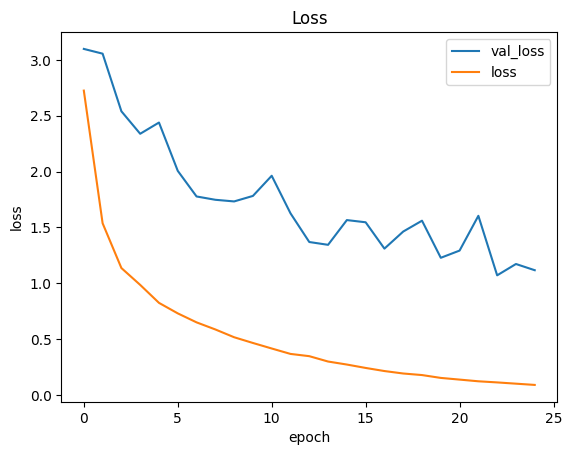

In [135]:
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title("Loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['val_loss','loss'])
plt.show()

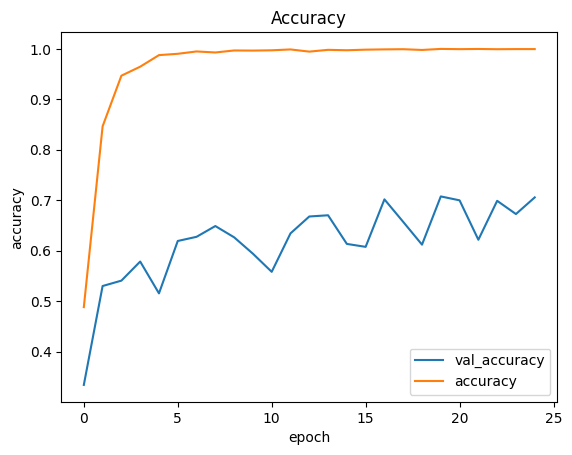

In [136]:
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.title("Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['val_accuracy','accuracy'])
plt.show()

In [141]:
model.save("manumano.keras")

In [ ]:
!wget https://github.com/ecabestadistica/sign-language-translator-python-opencv/raw/master/Code/modelmiguelnumber.h5

--2023-11-23 13:53:31--  https://github.com/ecabestadistica/sign-language-translator-python-opencv/raw/master/Code/modelmiguelnumber.h5
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ecabestadistica/sign-language-translator-python-opencv/master/Code/modelmiguelnumber.h5 [following]
--2023-11-23 13:53:31--  https://raw.githubusercontent.com/ecabestadistica/sign-language-translator-python-opencv/master/Code/modelmiguelnumber.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80301800 (77M) [application/octet-stream]
Saving to: ‘modelmiguelnumber.h5.1’

modelmiguelnumber.h 100%[===================

In [ ]:
model.load_weights("modelmiguelnumber.h5")

In [ ]:
model.load_weights("manumano.keras")

In [ ]:
model.evaluate(validation_ds)

65/65 [==============================] - 2s 21ms/step - loss: 1.7698 - accuracy: 0.5427


[1.7698214054107666, 0.5426769852638245]

In [137]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("normalized")
  else:
    print("without normalization")

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() /2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j,i, format(cm[i,j],fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

import numpy as np

y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in validation_ds:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)
print(predicted_labels)



1/1 [==============================] - 0s 181ms/step
tf.Tensor([4 5 7 ... 9 4 9], shape=(2062,), dtype=int64)


In [138]:
final_correct_labels = []
for lb in correct_labels:
  itlist=list(lb.numpy())
  final_correct_labels.append(itlist.index(1.0))

In [139]:

cm = confusion_matrix(predicted_labels, final_correct_labels)

without normalization
[[202   0   0   0   0   0   0   0   0   0]
 [  0 115  13   0   0   0   0   1   0   0]
 [  0  71 137   5   0   0   1   9   5   4]
 [  0   8  38 188   1   0   0   0  14   2]
 [  0   4   0   0 149  10  49  10  15  12]
 [  0   0   0  11  12 194   7   0   0  13]
 [  1   0   0   0  35   2 138  15  13  12]
 [  0   4  12   2   5   1  12 170 127   4]
 [  0   0   1   0   0   0   0   0   5   0]
 [  2   4   5   0   5   0   0   1  29 157]]


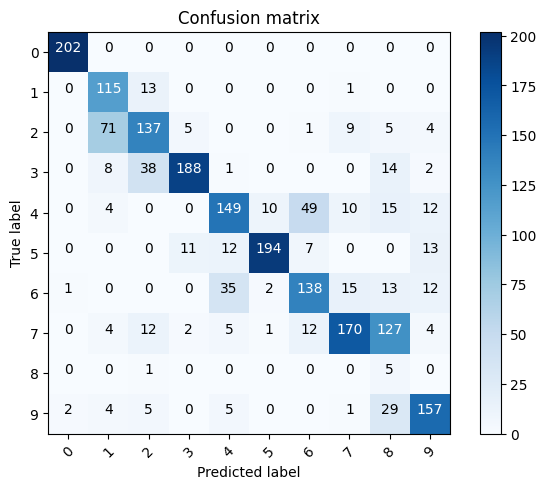

In [140]:
plot_confusion_matrix(cm,class_names)